# Anomaly Detection
This objective of this work is to detect failing servers on a network using anomaly detection algorithm
# Outline
- [ 1 - Packages ](#1)
- [ 2 - Anomaly detection](#2)
  - [ 2.1 Problem Statement](#2.1)
  - [ 2.2  Dataset](#2.2)
  - [ 2.3 Gaussian distribution](#2.3)
    - [ 2.3.1 Estimating parameters for a Gaussian distribution](#2.3.1)
    - [ 2.3.2 Selecting the threshold](#2.3.2)
  - [ 2.4 High dimensional dataset](#2.4)

<a name="1"></a>
## 1 - Packages 

First, import all the packages that will be needed during this work.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

<a name='2'></a>
## 2 - Anomaly Detection
<a name='2.1'></a>
### 2.1 - Problem Statement
In this work I will emplement anomaly detection algorithm to detect anomalous behaviour in server computers.

The dataset contains two features - 
   * throughput (mb/s) and 
   * latency (ms) of response of each server.
While the computer servers were operating, $m=307$ examples of how they were behaving were collected as an unlabeled dataset $\{x^{(1)}, \ldots, x^{(m)}\}$.  
* The vast majority of these examples should be “normal” (non-anomalous) examples of the servers operating normally, but there might also be some examples of servers acting anomalously within this dataset.

A Gaussian model is used here to detect anomalous examples in the dataset. 
* First, start on a 2D dataset that will allow a visualization on what the algorithm is doing.
* Fit a Gaussian distribution on the dataset and then find values that have very low probability and hence can be considered anomalies. 
* After that, apply the anomaly detection algorithm to a larger dataset with many dimensions. 

<a name="2.2"></a>
### 2.2  Dataset

Start by loading the dataset for this task. 
`X_train` is used to fit a Gaussian Distribution. `X_val` and `y_val` as a cross validation set to select a threshold and determine anomalous vs normal examples

In [3]:
X_train = np.load("data/X_part1.npy") 
X_val = np.load("data/X_val_part1.npy") 
y_val = np.load("data/y_val_part1.npy")

#### View the variables
Get more familiar with the  dataset by printing out each variable and see waht it contains.  

In [4]:
# Display the first five elements of X_train
print("The first 5 elements of X_train are:\n", X_train[:5])  

The first 5 elements of X_train are:
 [[13.04681517 14.74115241]
 [13.40852019 13.7632696 ]
 [14.19591481 15.85318113]
 [14.91470077 16.17425987]
 [13.57669961 14.04284944]]


In [5]:
# Display the first five elements of X_val
print("The first 5 elements of X_val are\n", X_val[:5])  

The first 5 elements of X_val are
 [[15.79025979 14.9210243 ]
 [13.63961877 15.32995521]
 [14.86589943 16.47386514]
 [13.58467605 13.98930611]
 [13.46404167 15.63533011]]


In [6]:
# Display the first five elements of y_val
print("The first 5 elements of y_val are\n", y_val[:5])  

The first 5 elements of y_val are
 [0 0 0 0 0]


#### Check the dimensions of the variables

In [7]:
print ('The shape of X_train is:', X_train.shape)
print ('The shape of X_val is:', X_val.shape)
print ('The shape of y_val is: ', y_val.shape)

The shape of X_train is: (307, 2)
The shape of X_val is: (307, 2)
The shape of y_val is:  (307,)


#### Visualize the data

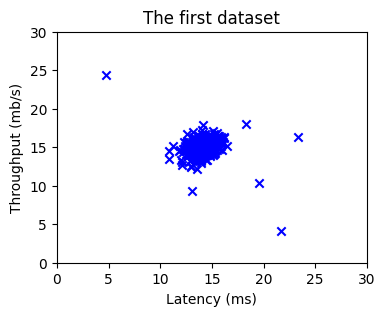

In [11]:
# Create a scatter plot of the data. 
plt.figure(figsize=(4,3))
plt.scatter(X_train[:, 0], X_train[:, 1], marker='x', c='b') 

# Set the title
plt.title("The first dataset")
# Set the y-axis label
plt.ylabel('Throughput (mb/s)')
# Set the x-axis label
plt.xlabel('Latency (ms)')
# Set axis range
plt.axis([0, 30, 0, 30])
plt.show()

<a name="2.3"></a>
### 2.3 Gaussian distribution

To perform anomaly detection, you will first need to fit a model to the data’s distribution.

* Given a training set $\{x^{(1)}, ..., x^{(m)}\}$ I want to estimate the Gaussian distribution for each
of the features $x_i$. 

* Recall that the Gaussian distribution is given by

   $$ p(x ; \mu,\sigma ^2) = \frac{1}{\sqrt{2 \pi \sigma ^2}}\exp^{ - \frac{(x - \mu)^2}{2 \sigma ^2} }$$

   where $\mu$ is the mean and $\sigma^2$ is the variance.
   
* For each feature $i = 1\ldots n$, I need to find parameters $\mu_i$ and $\sigma_i^2$ that fit the data in the $i$-th dimension $\{x_i^{(1)}, ..., x_i^{(m)}\}$ (the $i$-th dimension of each example).

<a name="2.3.1"></a>
### 2.3.1 Estimating parameters for a Gaussian distribution

We can estimate the parameters, ($\mu_i$, $\sigma_i^2$), of the $i$-th feature by using the following equations. 

$$\mu_i = \frac{1}{m} \sum_{j=1}^m x_i^{(j)}$$
$$\sigma_i^2 = \frac{1}{m} \sum_{j=1}^m (x_i^{(j)} - \mu_i)^2$$

In [15]:
def estimate_gaussian(X): 
    """
    Calculates mean and variance of all features 
    in the dataset
    Args:
        X (ndarray): (m, n) Data matrix
    Returns:
        mu (ndarray): (n,) Mean of all features
        var (ndarray): (n,) Variance of all features
    """
    m, n = X.shape
    mu = np.apply_along_axis(np.mean, axis=0, arr=X)
    var = np.apply_along_axis(np.var, axis=0, arr=X)
    return mu, var

In [17]:
mu, var = estimate_gaussian(X_train)              

**Now, visualize the contours of the fitted Gaussian distribution**

From the following plot we can see that most of the examples are in the region with the highest probability, while the anomalous examples are in the regions with lower probabilities.

In [22]:
def multivariate_gaussian(X, mu, var):
    """
    Computes the probability density function of the examples X under 
    the multivariate gaussian distribution with parameters mu and var. 
    """    
    k = len(mu) 
    var = np.diag(var)
    X = X - mu
    p = (2* np.pi)**(-k/2) * np.linalg.det(var)**(-0.5) * np.exp(-0.5 * np.sum(np.matmul(X, np.linalg.pinv(var)) * X, axis=1))   
    return p

In [25]:
def visualize_fit(X, mu, var):
    """
    This visualization shows the probability density function of the Gaussian distribution. 
    Each example has a location (x1, x2) that depends on its feature values.
    """ 
    X1, X2 = np.meshgrid(np.arange(0, 35.5, 0.5), np.arange(0, 35.5, 0.5))
    Z = multivariate_gaussian(np.stack([X1.ravel(), X2.ravel()], axis=1), mu, var)
    Z = Z.reshape(X1.shape)
    plt.figure(figsize=(4,3))
    plt.plot(X[:, 0], X[:, 1], 'bx')

    if np.sum(np.isinf(Z)) == 0:
        plt.contour(X1, X2, Z, levels=10**(np.arange(-20., 1, 3)), linewidths=1)
        
    # Set the title
    plt.title("The Gaussian contours of the distribution fit to the dataset")
    # Set the y-axis label
    plt.ylabel('Throughput (mb/s)')
    # Set the x-axis label
    plt.xlabel('Latency (ms)')

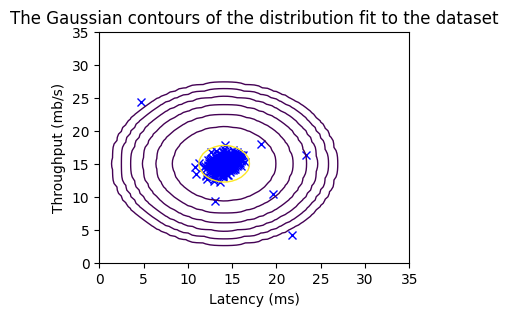

In [26]:
visualize_fit(X_train, mu, var)

<a name='2.3.2'></a>
### 2.3.2 Selecting the threshold $\epsilon$

Now that we have estimated the Gaussian parameters, we can investigate which examples have a very high probability given this distribution and which examples have a very low probability.  

* The low probability examples are more likely to be the anomalies in the dataset. 
* One way to determine which examples are anomalies is to select a threshold based on a cross validation set. 

In this section, I will select the threshold $\varepsilon$ using the $F_1$ score on a cross validation set.

* I will use a cross validation set
$\{(x_{\rm cv}^{(1)}, y_{\rm cv}^{(1)}),\ldots, (x_{\rm cv}^{(m_{\rm cv})}, y_{\rm cv}^{(m_{\rm cv})})\}$, where the label $y=1$ corresponds to an anomalous example, and $y=0$ corresponds to a normal example. 
* For each cross validation example, I will compute $p(x_{\rm cv}^{(i)})$. The vector of all of these probabilities $p(x_{\rm cv}^{(1)}), \ldots, p(x_{\rm cv}^{(m_{\rm cv})})$ is passed to `select_threshold` in the vector `p_val`. 
* The corresponding labels $y_{\rm cv}^{(1)}, \ldots, y_{\rm cv}^{(m_{\rm cv})}$ are passed to the same function in the vector `y_val`.

If an example $x$ has a low probability $p(x) < \varepsilon$, then it is classified as an anomaly. Then, we can compute precision and recall by: 
   $$\begin{aligned}
   prec&=&\frac{tp}{tp+fp}\\
   rec&=&\frac{tp}{tp+fn},
   \end{aligned}$$ where
* $tp$ is the number of true positives: the ground truth label says it’s an anomaly and our algorithm correctly classified it as an anomaly.
* $fp$ is the number of false positives: the ground truth label says it’s not an anomaly, but our algorithm incorrectly classified it as an anomaly.
* $fn$ is the number of false negatives: the ground truth label says it’s an anomaly, but our algorithm incorrectly classified it as not being anomalous.

The $F_1$ score is computed using precision ($prec$) and recall ($rec$) as follows:
    $$F_1 = \frac{2\cdot prec \cdot rec}{prec + rec}$$ 

In [35]:
def select_threshold(y_val, p_val): 
    """
    Finds the best threshold to use for selecting outliers 
    based on the results from a validation set (p_val) 
    and the ground truth (y_val) 
    Args:
        y_val (ndarray): Ground truth on validation set
        p_val (ndarray): Results on validation set
        
    Returns:
        epsilon (float): Threshold chosen 
        F1 (float):      F1 score by choosing epsilon as threshold
    """ 

    best_epsilon = 0
    best_F1 = 0
    F1 = 0
    
    step_size = (max(p_val) - min(p_val)) / 1000
    
    for epsilon in np.arange(min(p_val), max(p_val), step_size):
    
        ### START CODE HERE ### 
        predict = np.zeros(len(y_val))
        predict[p_val < epsilon] = 1
                
        tp = np.dot(predict, y_val)
        tp_fp = sum(predict)
        tp_fn = sum(y_val)
        prec = tp/tp_fp if tp_fp != 0 else -1
        rec = tp/tp_fn 
        
        F1 = 2*prec*rec/(prec+rec)
        
        if F1 > best_F1:
            best_F1 = F1
            best_epsilon = epsilon
        
    return best_epsilon, best_F1

In [36]:
p_val = multivariate_gaussian(X_val, mu, var)
epsilon, F1 = select_threshold(y_val, p_val)

print('Best epsilon found using cross-validation: %e' % epsilon)
print('Best F1 on Cross Validation Set: %f' % F1)

Best epsilon found using cross-validation: 8.990853e-05
Best F1 on Cross Validation Set: 0.875000


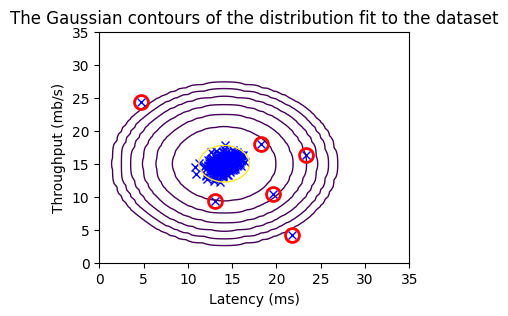

In [38]:
# Returns the density of the multivariate normal at each data point (row) of X_train
p = multivariate_gaussian(X_train, mu, var)
# Find the outliers in the training set 
outliers = p < epsilon
# Visualize the fit
visualize_fit(X_train, mu, var)
# Draw a red circle around those outliers
plt.plot(X_train[outliers, 0], X_train[outliers, 1], 'ro',
         markersize= 10,markerfacecolor='none', markeredgewidth=2)

<a name="2.4"></a>
## 2.4 High dimensional dataset
Now,  we will run the anomaly detection algorithm on a more realistic and much harder dataset.

In this dataset, each example is described by 11 features, capturing many more properties of the compute servers.

Let's start by loading the dataset.
- We will use `X_train_high` to fit Gaussian distribution 
- use `X_val_high` and `y_val_high` as a cross validation set to select a threshold and determine anomalous vs normal examples

In [39]:
X_train_high = np.load("data/X_part2.npy")
X_val_high = np.load("data/X_val_part2.npy")
y_val_high = np.load("data/y_val_part2.npy")

Let's check the dimensions of these new variables to become familiar with the data

In [40]:
print ('The shape of X_train_high is:', X_train_high.shape)
print ('The shape of X_val_high is:', X_val_high.shape)
print ('The shape of y_val_high is: ', y_val_high.shape)

The shape of X_train_high is: (1000, 11)
The shape of X_val_high is: (100, 11)
The shape of y_val_high is:  (100,)


#### Anomaly detection 

Now, let's run the anomaly detection algorithm on this new dataset.

* Estimate the Gaussian parameters ($\mu_i$ and $\sigma_i^2$)
* Evaluate the probabilities for both the training data `X_train_high` from which we estimated the Gaussian parameters, as well as for the the cross-validation set `X_val_high`. 
* Finally, it will use `select_threshold` to find the best threshold $\varepsilon$. 

In [41]:
# Estimate the Gaussian parameters
mu_high, var_high = estimate_gaussian(X_train_high)

# Evaluate the probabilites for the training set
p_high = multivariate_gaussian(X_train_high, mu_high, var_high)

# Evaluate the probabilites for the cross validation set
p_val_high = multivariate_gaussian(X_val_high, mu_high, var_high)

# Find the best threshold
epsilon_high, F1_high = select_threshold(y_val_high, p_val_high)

print('Best epsilon found using cross-validation: %e'% epsilon_high)
print('Best F1 on Cross Validation Set:  %f'% F1_high)
print('# Anomalies found: %d'% sum(p_high < epsilon_high))

Best epsilon found using cross-validation: 1.377229e-18
Best F1 on Cross Validation Set:  0.615385
# Anomalies found: 117
